# 프로젝트: 주식 예측에 도전해 보자

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.12.1


## STEP 1 : 시계열 데이터 준비


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 03/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
ts = df['Close']

ts.head()

0    48800.0
1    50300.0
2    50000.0
3    49950.0
4    48750.0
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')

ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환
ts_log = np.log(ts)

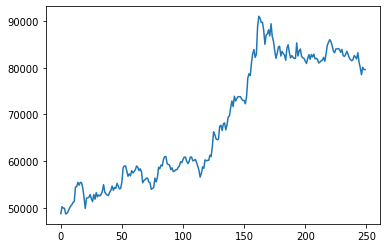

In [5]:
plt.plot(ts)

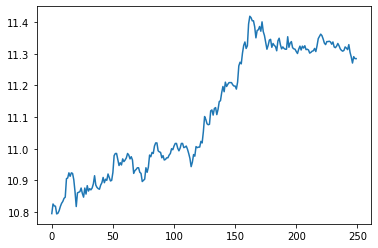

In [6]:
plt.plot(ts_log)

- 로그 변환을 취하는 것은 불안정 시계열을 안정 시계열로 변환하는 방법중 하나로 그래프가 0 근처에서 치우쳐있을 때 중간으로 옮기는 용으로 쓴다고 배웠는데 본 데이터에서는 큰 영향이 없는 듯 하지만, 노드에서 로그 변환을 하라고 해서 함. 


## STEP 3: 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

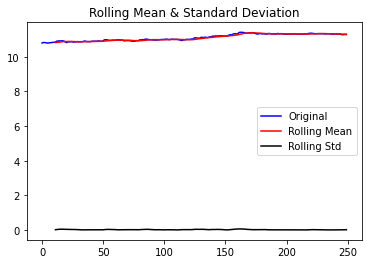

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [8]:
## Log 변환 한 원본데이터의 안정성 분석 

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


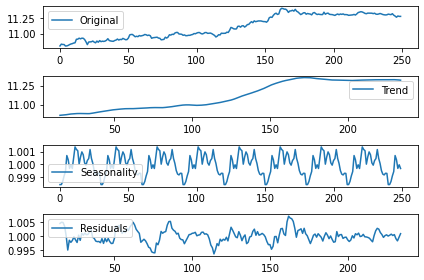

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [10]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4: 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

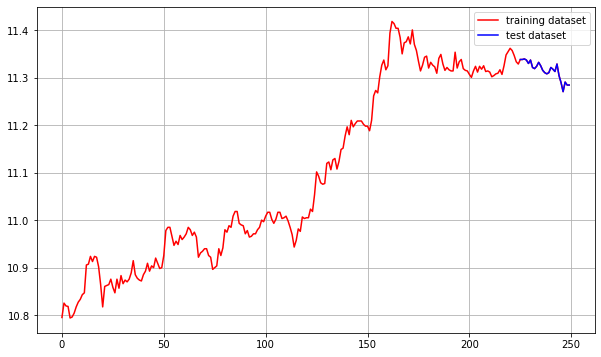

In [11]:
# train 과 test 데이터셋을 9:1로 분리함. 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5: 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기


* 자기 상관 함수 (Autocorrelation Function, ACF)
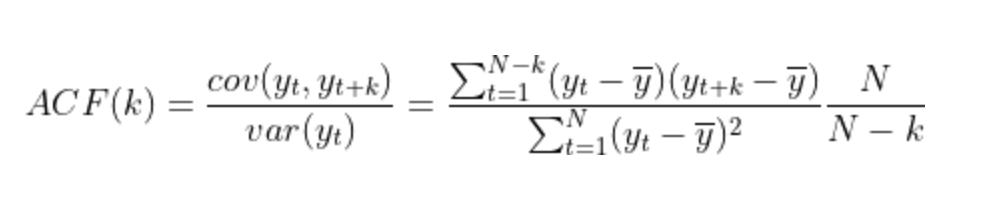

* 편자기상관함수 (Partial Autocorrelation Fucntion, PACF)]
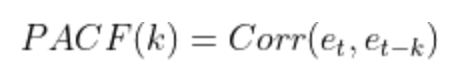
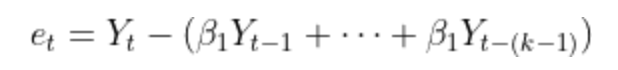



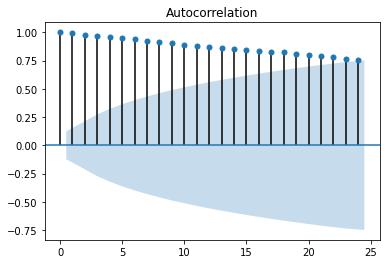

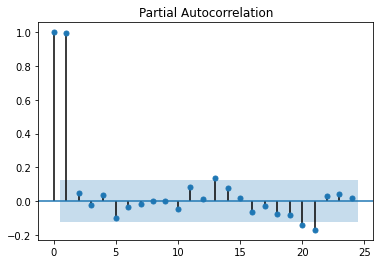

In [12]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


- ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음

- PACF 그래프를 보면 p = 1이 적합. p가 2 이상인 구간에서는 PACF 가 0에 가까워지고 있기 때문.

- ACF 는 점차적으로 감소하고 있어서 AR(a)모델에 유사한 형태. q에 대한 적합한 값은 없어 보임. MA를 고려할 필요가 없어서 q = 0. 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


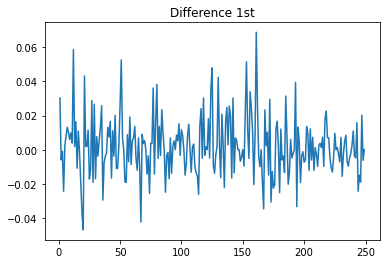

In [13]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

- 1차 차분에서도 충분히 안정된 상태여서 d = 1

## STEP 6: ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [14]:
!pip install statsmodels==0.12.1

In [15]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Thu, 05 May 2022   AIC                          -1158.741
Time:                        14:28:47   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

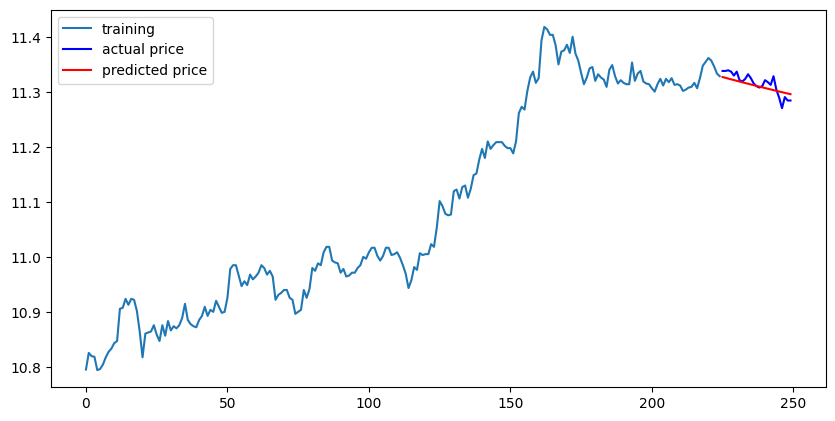

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1057119.8161341746
MAE:  850.8270312481956
RMSE:  1028.163321721882
MAPE: 1.04%


## STEP 7: 다른 주식 종목 예측해보기

## 데이터1. 카카오 주식 (2021.05.05~2022.05.05 / Historical Prices / Daily) 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath1 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 03/035720.KS.csv' 
df1 = pd.read_csv(dataset_filepath1) 
ts1 = df1['Close']

ts1.head()

0    115000.0
1    114500.0
2    116000.0
3    114500.0
4    113000.0
Name: Close, dtype: float64

In [19]:
# 결측치 처리
ts1 = ts1.interpolate(method='time')

ts1[ts1.isna()]  

Series([], Name: Close, dtype: float64)

In [20]:
# 로그 변환
ts1_log = np.log(ts1)

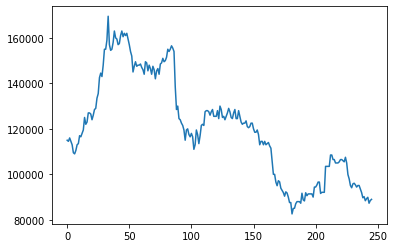

In [21]:
plt.plot(ts1)

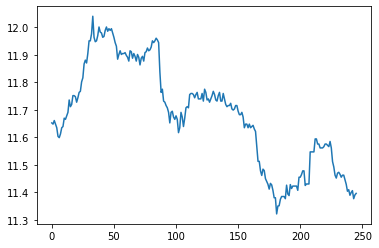

In [22]:
plt.plot(ts1_log)

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

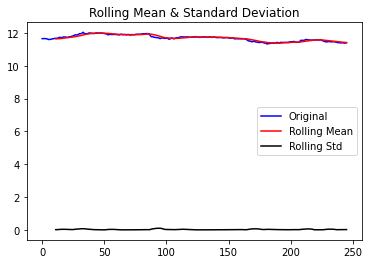

Results of Dickey-Fuller Test:
Test Statistic                  -0.696216
p-value                          0.847727
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


In [24]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)


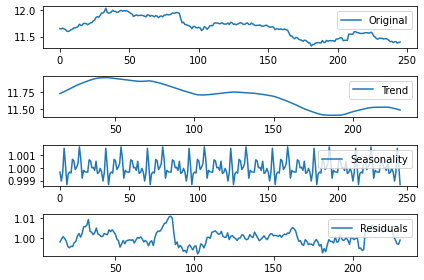

In [25]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.479762
p-value                          0.000214
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


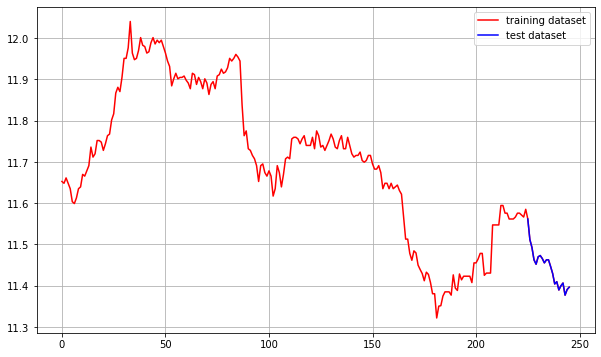

In [27]:
# train 과 test 데이터셋을 9:1로 분리함. 
train_data, test_data = ts1_log[:int(len(ts_log)*0.9)], ts1_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

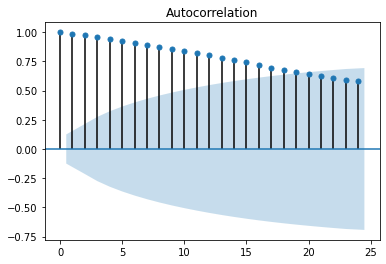

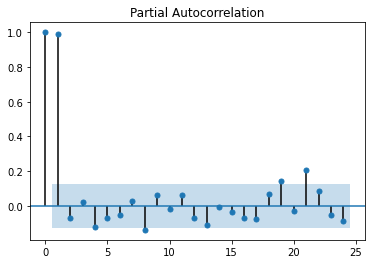

In [28]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 삼성전자 주식과 비슷한 경향을 보임, p = 1, q = 0


Results of Dickey-Fuller Test:
Test Statistic                -7.608130e+00
p-value                        2.293053e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


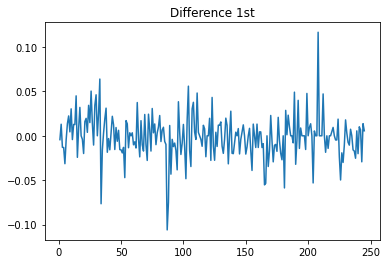

In [29]:
# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 역시 1차 차분에서도 안정적이라서 d = 1

In [30]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 515.155
Date:                Thu, 05 May 2022   AIC                          -1022.309
Time:                        14:28:50   BIC                          -1008.645
Sample:                             0   HQIC                         -1016.794
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6626      0.189     61.754      0.000      11.292      12.033
ar.L1          0.9907      0.008    116.790      0.000       0.974       1.007
ma.L1          0.0463      0.056      0.827      0.4

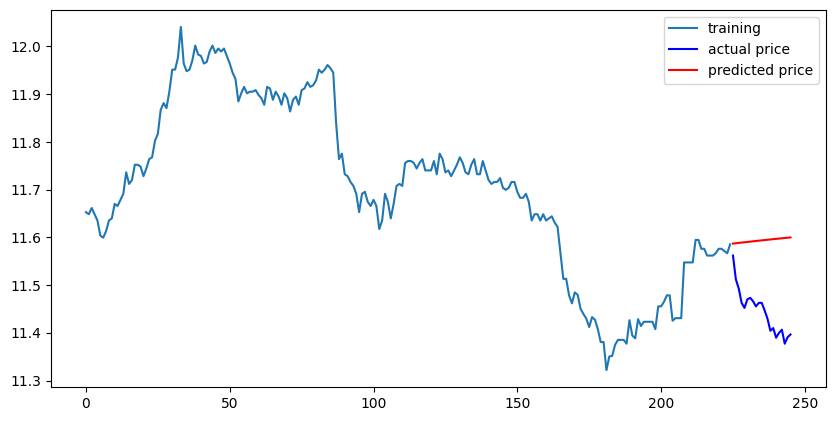

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  245671038.34383044
MAE:  14960.229698352781
RMSE:  15673.89671855185
MAPE: 16.27%


- 삼성전자와 같이 ARIMA (1,0,1) 모델로 학습했을 때는 오차율이 16.27%로 크게 나왔다. 

- 카카오 주가의 정상성을 확인했을 때 삼성전자의 주가보다는 p value 값이 높았는데 이로 인해 오차율이 커진 것 같다. 

- p,d,q 를 변화시켜서 모델학습을 진행하기 위해 검색하는 중 pmdarima 라는 모듈을 발견해서 적용해보았다.


In [33]:
pip install pmdarima

In [34]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1023.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1021.783, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1021.839, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1025.440, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1019.808, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 513.720
Date:                Thu, 05 May 2022   AIC                          -1025.440
Time:                        14:28:53   BIC                          -1022.028
Sample:                             0   HQIC                         -1024.063
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   3.33e-05     17.898      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               129.29
Prob(Q):                              0.58   Pr

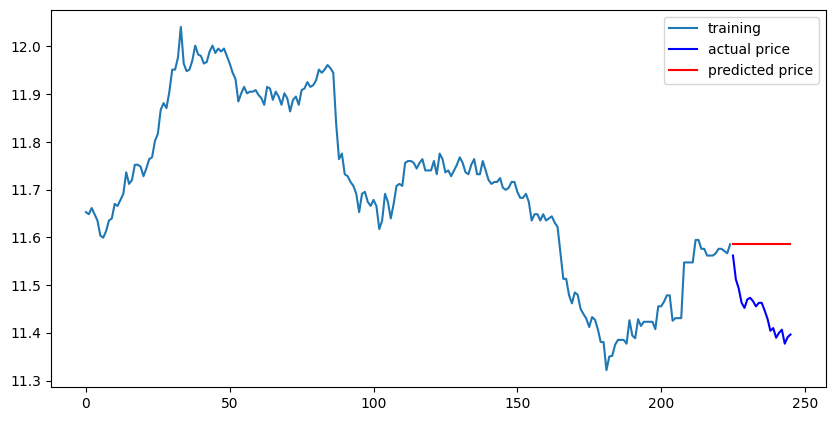

In [35]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  216507619.04762027
MAE:  14076.190476190515
RMSE:  14714.197873061932
MAPE: 15.30%


- 여전히 오차가 15% 이상이 나와서 데이터를 살펴보았다. 삼성전자 주가와는 다르게 하락과 상승이 반복해서 학습데이터의 비율이 크게 잡혀서 그런 것 같아 비율을 조절했다. 

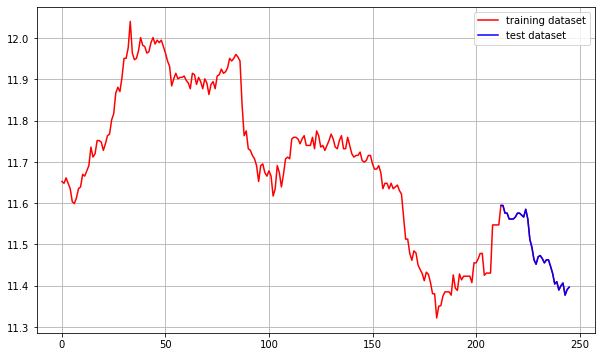

In [37]:
# train 과 test 데이터셋을 8.5:1.5로 분리함. 
train_data, test_data = ts1_log[:int(len(ts_log)*0.85)], ts1_log[int(len(ts_log)*0.85):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [38]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-956.530, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-954.835, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-954.887, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-958.445, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-952.858, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.380 seconds


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  212
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 480.223
Date:                Thu, 05 May 2022   AIC                           -958.445
Time:                        14:28:54   BIC                           -955.093
Sample:                             0   HQIC                          -957.090
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006    3.6e-05     17.168      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               113.36
Prob(Q):                              0.58   Pr

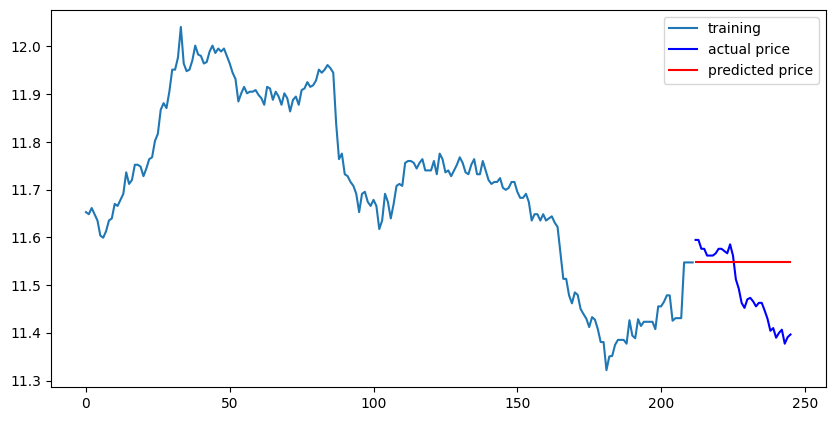

In [39]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [40]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  77672352.94117707
MAE:  7400.000000000027
RMSE:  8813.191983678618
MAPE: 7.90%


## 데이터2. Tesla 주식 (2021.05.05~2022.05.05 / Historical Prices / Daily) 





In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath2 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 03/TSLA.csv' 
df2 = pd.read_csv(dataset_filepath2) 
ts2 = df2['Close']

ts2.head()

0    670.940002
1    663.539978
2    672.369995
3    629.039978
4    617.200012
Name: Close, dtype: float64

In [42]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')

ts2[ts2.isna()]  

Series([], Name: Close, dtype: float64)

In [43]:
# 로그 변환
ts2_log = np.log(ts2)

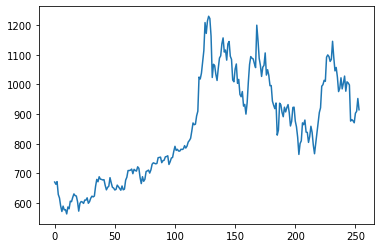

In [44]:
plt.plot(ts2)

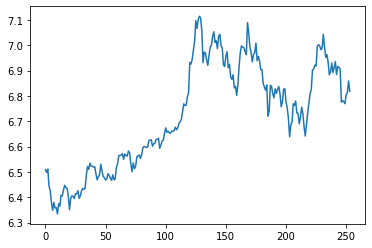

In [45]:
plt.plot(ts2_log)

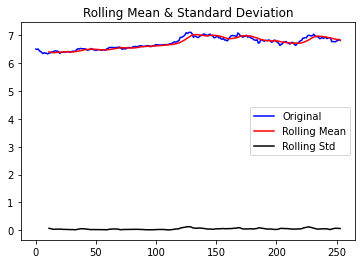

Results of Dickey-Fuller Test:
Test Statistic                  -1.477234
p-value                          0.544742
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)


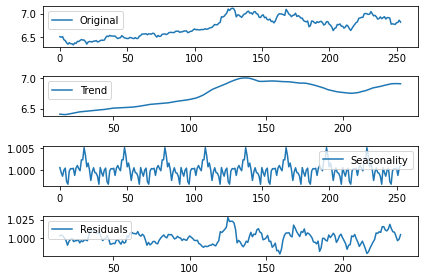

In [47]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.744369e+00
p-value                        3.061530e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


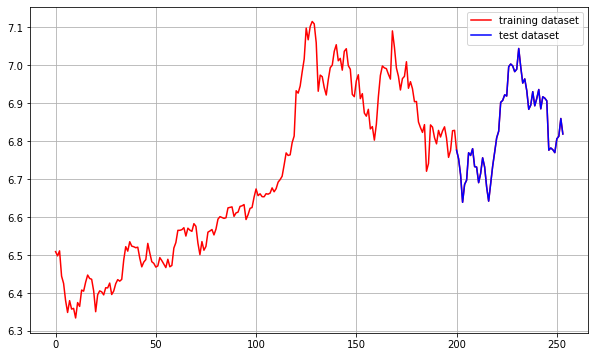

In [49]:
# train 과 test 데이터셋을 8:2로 분리함. 
train_data, test_data = ts2_log[:int(len(ts_log)*0.8)], ts2_log[int(len(ts_log)*0.8):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

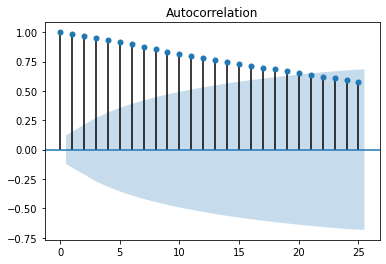

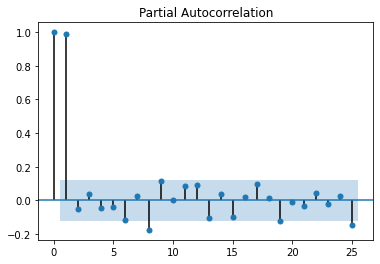

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 삼성전자 주식과 비슷한 경향을 보임, p = 1, q = 0



Results of Dickey-Fuller Test:
Test Statistic                -5.721941e+00
p-value                        6.909049e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


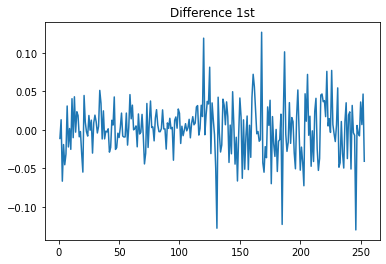

In [51]:
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 역시 1차 차분에서도 안정적이라서 d = 1

In [52]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 398.385
Date:                Thu, 05 May 2022   AIC                           -788.771
Time:                        14:28:56   BIC                           -775.577
Sample:                             0   HQIC                          -783.432
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6824      0.176     37.867      0.000       6.336       7.028
ar.L1          0.9878      0.011     91.998      0.000       0.967       1.009
ma.L1          0.0071      0.072      0.099      0.9

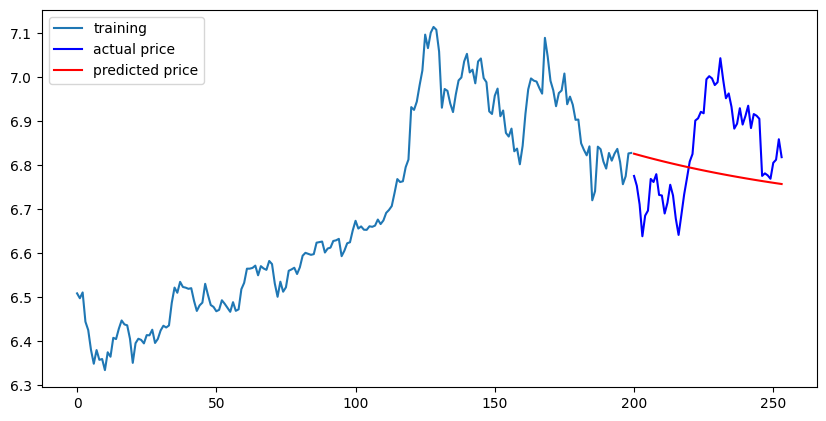

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [54]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14559.599762609367
MAE:  103.51198804506454
RMSE:  120.66316655305117
MAPE: 10.75%


## 데이터3. Apple 주식 (2021.05.05~2022.05.05 / Historical Prices / Daily) 





In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath3 = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 03/AAPL.csv' 
df3 = pd.read_csv(dataset_filepath3) 
ts3 = df3['Close']

ts3.head()

0    128.100006
1    129.740005
2    130.210007
3    126.849998
4    125.910004
Name: Close, dtype: float64

In [56]:
# 결측치 처리
ts3 = ts3.interpolate(method='time')

ts3[ts3.isna()]  

Series([], Name: Close, dtype: float64)

In [57]:
# 로그 변환
ts3_log = np.log(ts3)

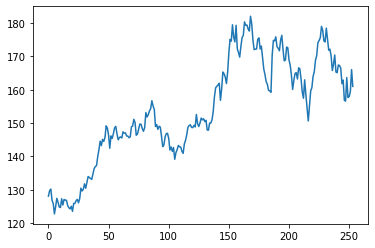

In [58]:
plt.plot(ts3)

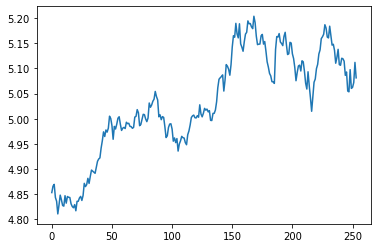

In [59]:
plt.plot(ts3_log)

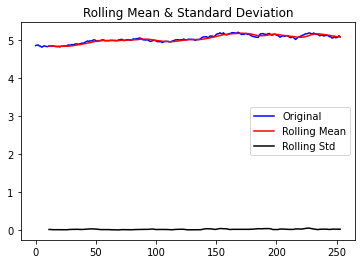

Results of Dickey-Fuller Test:
Test Statistic                  -1.961506
p-value                          0.303702
#Lags Used                       8.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [60]:
# 정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)


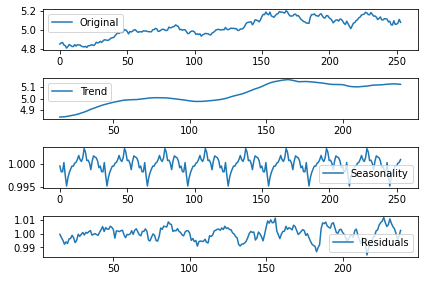

In [61]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [62]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.613503
p-value                          0.000122
#Lags Used                       8.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


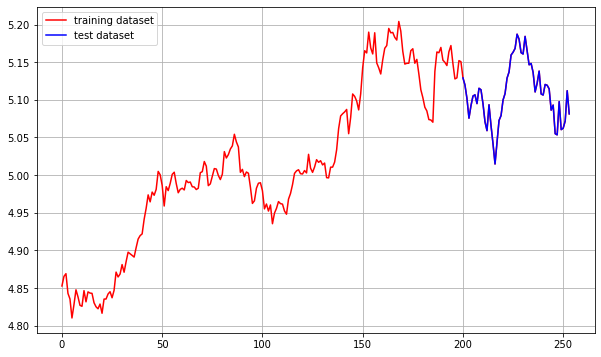

In [63]:
# train 과 test 데이터셋을 8:2로 분리함. 
train_data, test_data = ts3_log[:int(len(ts_log)*0.8)], ts3_log[int(len(ts_log)*0.8):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

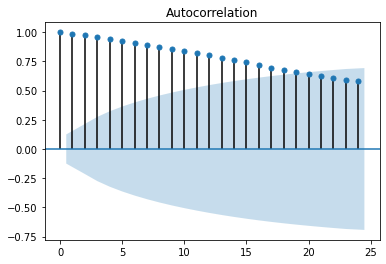

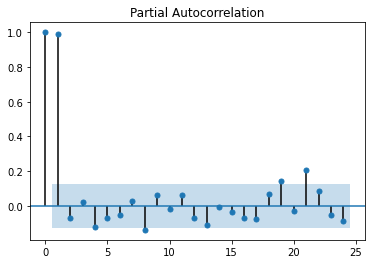

In [64]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 삼성전자 주식과 비슷한 경향을 보임, p = 1, q = 0





Results of Dickey-Fuller Test:
Test Statistic                -5.974793e+00
p-value                        1.898744e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


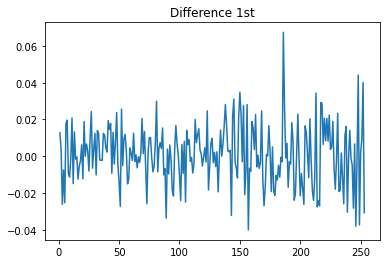

In [65]:
# 1차 차분 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 역시 1차 차분에서도 안정적이라서 d = 1

In [66]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 559.553
Date:                Thu, 05 May 2022   AIC                          -1111.107
Time:                        14:28:59   BIC                          -1097.914
Sample:                             0   HQIC                         -1105.768
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0098      0.060     83.525      0.000       4.892       5.127
ar.L1          0.9884      0.010     97.372      0.000       0.968       1.008
ma.L1          0.0866      0.068      1.270      0.2

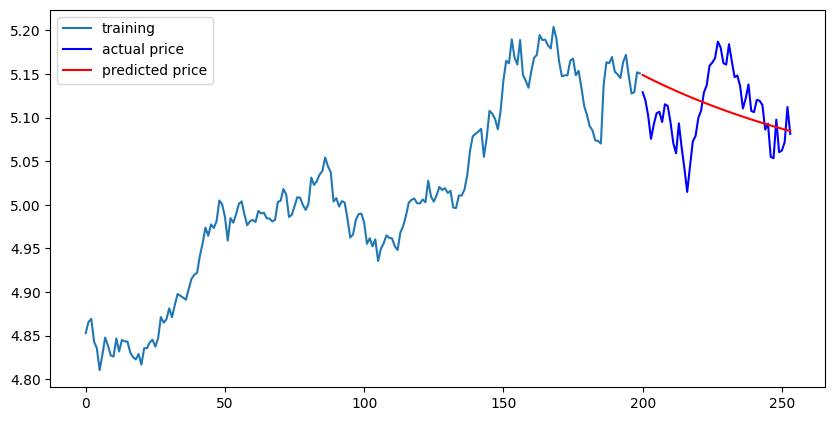

In [67]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
#오차율 계산하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  55.87553560361595
MAE:  6.372174882052507
RMSE:  7.474994020306368
MAPE: 3.86%


# 회고

- 시계열 데이터와 관련된 내용은 처음 접하는 것이어서 이해하는데 상당한 어려움을 겪었다. 여전히 P-value와 p,d,q의 정확한 개념을 이해하진 못하고 있다. 추후 통계학을 공부할 예정이다. 

-  Arima 모델의 p,d,q 값을 정하는 것도 중요하겠지만, 학습데이터와 테스트데이터의 분리 역시 모델 학습에서 중요한 요소임을 학인할 수 있었다. 